## Daniel Suañez Ramirez PS4
### ABHI Model: General Equilibrium Model

In [14]:
import numpy as np
from numba import jit
import quantecon as qe
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

General Equilibrium theory attempts to explain the behavior of supply, demand, and prices in a whole economy with several or many interacting markets, by seeking to prove that the interaction of demand and supply will result in an overall general equilibrium. General equilibrium theory contrasts to the theory of partial equilibrium, which only analyzes single markets. In general equilibrium, constant influences are considered to be noneconomic, therefore, resulting beyond the natural scope of economic analysis. Specially, prices are determined solving the problem, so wage and interest rate are not exogenous. To solve this problem, We are proce following QuantEcon. 

The production function is a Cobb-Douglas function. Thus:

\begin{equation}
Y = AK^{\alpha}N^{1-\alpha}
\end{equation}

The maximization problem os the firm is given by:
\begin{equation}
\max_{K, N} = Y -(r+\delta)K - \omega N
\end{equation}

From the FOC, we obtain the optimal interes rate:
\begin{equation}
r = A\alpha(\dfrac{N}{K})^{1-\alpha} - \delta
\end{equation}

we will proceed on the same path to obtain the optimal salary:
\begin{equation}
\omega = A(1-\alpha)\left(\dfrac{A\alpha}{r+\delta}\right)^{\dfrac{\alpha}{1-\alpha}}
\end{equation}



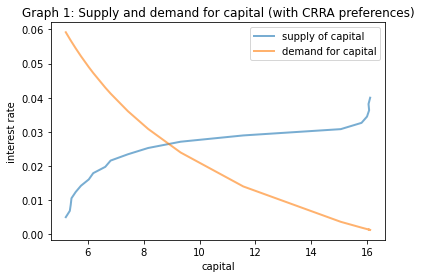

In [17]:
class Household:
    def __init__(self,
                 r=0.01,                      # interest rate
                 w=1.0,                       # wages
                 β=1/(1+0.04),                # discount factor
                 a_min=1e-10,
                 Π=[[0.6, 0.4], [0.4, 0.6]],  # Markov chain
                 z_vals=[0.3, 1.3],           # exogenous states
                 a_max=18,
                 a_size=100):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices.  Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w)


@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = (pow(c,1-4)-1)/(1-4)   # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
    return a_probs

@jit(nopython=True)
def consumption_marginal(s_probs, a_size, z_size):
    c_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            c_probs[a_i] += s_probs[a_i * z_size + z_i]
    return c_probs

#Parameters
A = 1.0 
N = 1.0  #Normalized labor (to 1)
α = 0.33 #Capital share
β = 1/(1+0.04)
δ = 0.05  #Depreciation


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=30)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots()
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')
plt.title('Graph 1: Supply and demand for capital (with CRRA preferences)')

plt.show()

The equilibrium interest rate is close to 3\% for the economy under GE. Moreover the supply for the assetr is limited, increasing very slow across time (blue line).

Text(0.5, 1.0, 'Graph 2: Stationary distribution of assets')

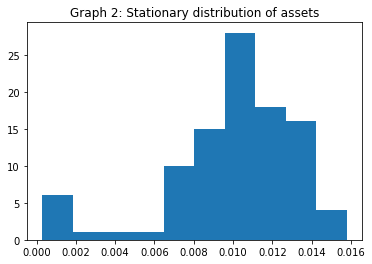

In [18]:
# Report the endogenous distribution of wealth. 

#STEP 1: Stationary distribution of wealth. 
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
# Compute the stationary distribution
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

#PLOT
plt.hist(asset_probs)
plt.title('Graph 2: Stationary distribution of assets')

The model is not rigid enough the account either for very egalitarian distributions or for very unequal ones.  

In [19]:
#REPORT SOME STATISTICS


def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

print('Average assets:'"{0:.4f}".format(np.mean(asset_probs)))
print('Standard deviation assets:'"{0:.4f}".format(np.std(asset_probs)))
print('Gini coefficient:'"{0:.4f}".format(gini(asset_probs)))
print('80/20 ratio:'"{0:.4f}".format(np.percentile(asset_probs,80)/np.percentile(asset_probs,20)))

order=sorted(asset_probs)
top1=order[99]/np.sum(order)
top10=np.sum(order[90:99])/np.sum(order)
bottom50=np.sum(order[0:50])/np.sum(order)
middle=np.sum(order[50:90])/np.sum(order)
print('Top 1% share:'"{0:.2f}".format(top1))
print('Top 10% share:'"{0:.2f}".format(top10))
print('Bottom 50% share:'"{0:.2f}".format(bottom50))
print('Middle class share:'"{0:.2f}".format(middle))

Average assets:0.0100
Standard deviation assets:0.0032
Gini coefficient:0.1698
80/20 ratio:1.5472
Top 1% share:0.02
Top 10% share:0.13
Bottom 50% share:0.39
Middle class share:0.47


In this particular specification the Gini Index is very low. One of the key mechanisms to change the stationary distribution is the transition matrix and the standard deviation of income shocks.

### Aiyagari Model (1994)

Aiyagari specification:

The utility function follow a CRRA, the risk aversion parameter $\lambda$ have the values $\{1,3,5\}$. Also, the discount factor is 0.96 whereas capital share is 0.36. The capital is depreciated at 0.08. Income process$ y = {-3\sigma, -2\sigma, -\sigma, 0, \sigma, 2\sigma, 3\sigma}$. the borrowing limit is 0. We put the focus in $\lambda = 3 $

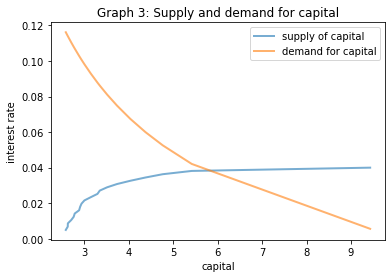

In [16]:
class Household:

    def __init__(self,
                 r=0.01,                # interest rate
                 w=1.0,                 # wages
                 β=0.96,                # discount factor
                 a_min=0,
                 Π=[[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05], [0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05], [0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05]],  # Markov chain
                 z_vals=[0.01, 0.2, 0.4, 0.6, 0.8, 1, 1.2],
                 a_max=18,
                 a_size=100):

 #Some comments on the stochastic income process: the code does not work if we 
 #include negative states; we do not very well how to get the transition probabilities
 #so, we came up with a creative transition matrix, that it's different from Aiyagari's one. 

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices.  Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w)

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = (pow(c,1-3)-1)/(1-3)   # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
    return a_probs

@jit(nopython=True)
def consumption_marginal(s_probs, a_size, z_size):
    c_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            c_probs[a_i] += s_probs[a_i * z_size + z_i]
    return c_probs

#Parameters
A = 1.0 
N = 1.0  #Normalized labor (to 1)
α = 0.36 #Capital share
β = 0.96
δ = 0.08  #Depreciation


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)

# Create an instance of Household
am = Household(a_max=30)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots()
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')
plt.title('Graph 3: Supply and demand for capital')

plt.show()

Using calibration for the Aiyagari model, so no one can borrow in this economy. We can observe the distribution of wealth in the next graph and also the equilibrium interest rate above.

Text(0.5, 1.0, 'Graph 4: Stationary distribution of assets')

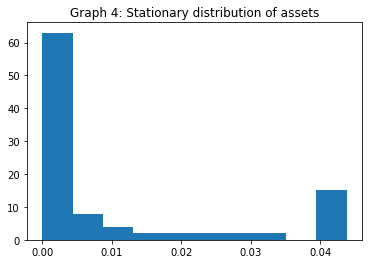

In [10]:
# Report the endogenous distribution of wealth. 

#STEP 1: Stationary distribution of wealth. 
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
# Compute the stationary distribution
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

#PLOT
plt.hist(asset_probs)
plt.title('Graph 4: Stationary distribution of assets')

In [11]:
#REPORT SOME STATISTICS


def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

print('Aggregate wealth:'"{0:.2f}".format(np.sum(asset_probs)))
print('Average assets:'"{0:.4f}".format(np.mean(asset_probs)))
print('Standard deviation assets:'"{0:.4f}".format(np.std(asset_probs)))
print('Gini coefficient:'"{0:.4f}".format(gini(asset_probs)))
print('80/20 ratio:'"{0:.2f}".format(np.percentile(asset_probs,80)/np.percentile(asset_probs,20)))
order=sorted(asset_probs)
top1=order[99]/np.sum(order)
top10=np.sum(order[90:99])/np.sum(order)
bottom50=np.sum(order[0:50])/np.sum(order)
middle=np.sum(order[50:90])/np.sum(order)
print('Top 1% share:'"{0:.2f}".format(top1))
print('Top 10% share:'"{0:.2f}".format(top10))
print('Bottom 50% share:'"{0:.2f}".format(bottom50))

Aggregate wealth:1.00
Average assets:0.0100
Standard deviation assets:0.0152
Gini coefficient:0.7220
80/20 ratio:3186.25
Top 1% share:0.04
Top 10% share:0.37
Bottom 50% share:0.01


The Gini coefficient is 0.727, so we have an unequal distribution, with lot of people in the extreme values, more or less this reproduce the wealth inequality reported by Krueger, Mitman and Perri.